# Checkpoint 2: Convolutional neural networks and autoencoders
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)



In this checkpoint exercise we will use the Quick Draw dataset. 

The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The bitmap dataset contains these drawings converted from vector format into 28x28 grayscale images.

We will focus on a subset of 10 classes of type "body part"

The class labels are:

![listbodypart](./list_body_parts.png)

| <p align='left'> Label                   | <p align='left'> Description| 
| ---------------------------------------- | --------------------------- |
| <p align='left'> 0                       | <p align='left'> arm        |
| <p align='left'> 1                       | <p align='left'> ear        | 
| <p align='left'> 2                       | <p align='left'> eye        |  
| <p align='left'> 3                       | <p align='left'> face      | 
| <p align='left'> 4                       | <p align='left'> foot       | 
| <p align='left'> 5                       | <p align='left'> hand       | 
| <p align='left'> 6                       | <p align='left'> knee       |
| <p align='left'> 7                       | <p align='left'> leg        |
| <p align='left'> 8                       | <p align='left'> mouth      |
| <p align='left'> 9                       | <p align='left'> nose     |


Players draw items as quickly as possible, and as you can see, some images are quite bad! We will try and train a CNN classifier to anyway see if we can train a model to distinguish the classes. We will then train an autoencoder to learn a laten space representations of the dataset.

    
This week, like last, I am not providing example notebooks like `lecture2.ipynb` and `data-science-tools.ipynb` for Unit 2, though these may still be useful to you. Instead, I am **providing the imports for all of the modules and classes that you should need.** 

### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 22 October 2021** 
- This CP exercise sheet is divided into **5 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title          | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ---------------------------------------- | --------------------- | -------------------- |
| <p align='left'> 1. Visualisation and Abstraction   | <p align='left'>   1  | <p align='left'> 1.5 |
| <p align='left'> 2. Image classification | <p align='left'> 2–5  | <p align='left'> 3.5 | 
| <p align='left'> 3. Auto-encoders        | <p align='left'> 6–9  | <p align='left'> 3.0 |
| <p align='left'> 4. Anomaly detection    | <p align='left'> 10–11| <p align='left'> 2.0 |
| <p align='left'> **Total**               |                       | <p align='left'> **10** |

---
You can find the dataset for download at [this link](https://cernbox.cern.ch/index.php/s/obvLeyMR0JEEa5p).
---
---

## Preamble
---

In [43]:
# Standard import(s)
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


In [2]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import regularizers

from tensorflow.python.keras.backend import set_image_data_format
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

## Data preprocessing (given, not marked)
---

First, we'll load in the preprocessed dataset from a numpy data file, which has already been split into training and testing parts for us.



* Each image has been **Reshaped to** $(N,N,1)$ dimension, i.e. image has one color dimention
* Images have been **Scaled** to have pixel intensities in the range [0,1]. It is an important step before feeding them to the neural network model, by dividing the values by 255. It's important that the training set and the testing set be preprocessed in the same way.
* Dataset was **Shuffled** for both training and testing datasets separately.
* Check the shapes of the resulting arrays; make sure they look as you expect.

In [3]:
#Load quickdraw bodyparts dataset
X_train, y_train, X_test, y_test = np.load('quickdraw_bodyparts.npy',allow_pickle=True) 


In [4]:
#Image labels
body_parts = ['arm', 'ear', 'eye', 'face','foot', 'hand', 'knee', 'leg', 'mouth','nose']

In [5]:
# Each label of the dataset correspond to a class name
class_names = body_parts

nb_train   = X_train.shape[0]
nb_test    = X_test.shape[0]
nb_classes = y_train.max() + 1
print("Number of training examples: {}".format(nb_train))
print("Number of testing  examples: {}".format(nb_test))
print("Number of target classes:    {}".format(nb_classes))

# Get image shape
shape = X_train.shape[1:]
print("Image shape:  {}".format(shape))

Number of training examples: 160000
Number of testing  examples: 40000
Number of target classes:    10.0
Image shape:  (28, 28, 1)


Shapes are as expected. 10 unique target labels and 28x28 greyscale input images.

## Image visualisation and abstraction (1.5 marks)

#### 1. Display images of the training dataset, and check that the associated label makes sense (0.5 mark)

You will use `matplotlib.pyplot`, the `plt.imshow` method. Use the `cmap=plt.cm.binary` color map for all subsequent img plots.

1. plot 10 training dataset images, one per category. Label the images.

In [6]:
def plot_img(fig, index, X, y=None, width=5, height=2):
    # To place an image at an index on a subplot grid with labels
    ax = fig.add_subplot(height, width, index)
    ax.title.set_text(body_parts[int(y)])
    # Take off axis ticks as they are unnecessary
    ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False)
    ax.imshow(X, cmap=plt.cm.binary)

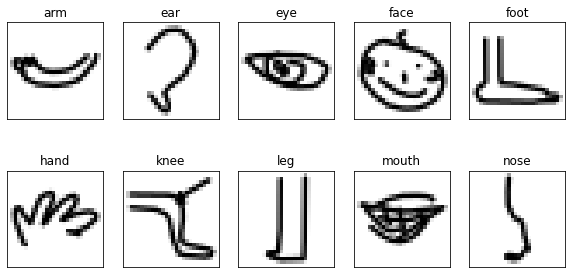

In [7]:
fig10 = plt.figure(figsize=(10,5))
body_part_indices = []

# Find the first index where a body part appears in training set and add to list
for i in range(int(nb_classes)):
    body_part_index = np.where(y_train==i)[0][0]
    body_part_indices.append(body_part_index)

# Plot the images at those selected indices to a grid
for i in range(int(nb_classes)):
    plot_img(fig10, i+1, X_train[body_part_indices[i]], y_train[body_part_indices[i]])

2. plot the fist 25 images in a 5x5 plot. Label the images.

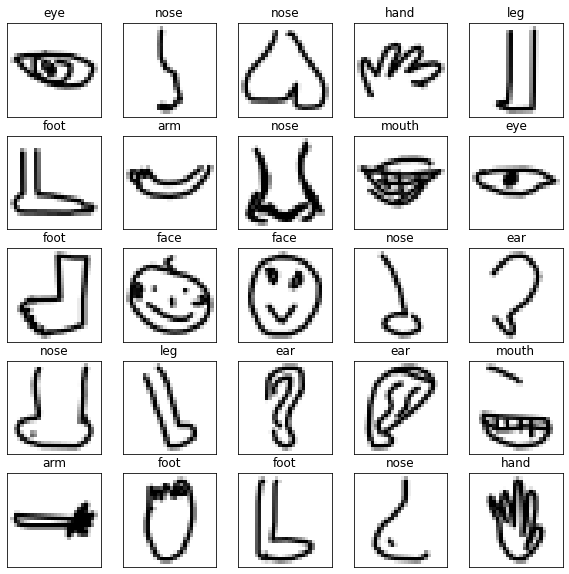

In [8]:
fig25 = plt.figure(figsize=(10,10))
# Plot first 25 to grid
for i in range(25):
    plot_img(fig25, i+1, X_train[i], y_train[i], height=5)

#### 2 Apply different kernels to an image of type face (1 mark)

1. pick an image of the face type and save it to `myface`. Plot it with `imshow` (nothing fancy needed for the plot)

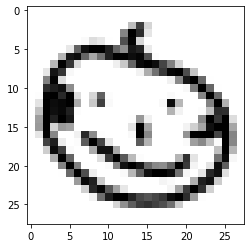

In [9]:
# First index of a face input in training set
face_index = np.where(y_train==3)[0][0]
myface = X_train[face_index]
plt.imshow(myface, cmap=plt.cm.binary)

2. Define 4 kernels: identity, edge_detection, sharpening, and blurring, as `3x3` numpy arrays. We add them to a dictionary of kernels.

In [10]:
# From lecture slides
k_identity = np.array([[0, 0, 0],
                       [0, 1, 0],
                       [0, 0, 0]])

k_edge = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])

k_sharp = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])

k_blur = np.ones((3, 3))/9

kernels = {"identity":k_identity,"edge":k_edge,"sharp":k_sharp,"blur":k_blur}

3. Given is part of the `run_kernel` function which runs over the figure and applies the kernel to every non-edge pixel. Complete the function:
    - Define the shape of the output image `np.empty(...)`
    - Define the ranges of the row and colum loops , i.e. `range(...)`
    - Define the fig index on which the kernel is multiplied in each step, ie. `fig[....]`



In [11]:
def run_kernel(fig,kernel):
    #empty array holding the output image. Define the output dimensions as excercise.
    # top, bottom, left, right edges not included so 2 less rows and columns than input image
    out = np.empty((shape[1]-2, shape[0]-2, 1))
    # ranges chosen to fully populate 2D out array
    for i in range(len(out[0])):
        for j in range(len(out[1])):
            # Slice a 3x3 grid of greyscale values each time until whole grid covered, ie out is fully populated
            out[i][j] = np.sum(np.multiply(kernel,fig[i:i+3, j:j+3, 0]))
                
    return out

4. run the plotting code block below and check that the kernels are doing what you expect.
    
Since some kernels multiply by negatives, we use the norm=norm(0,1) to scale the image back to between 0 and 1 before plotting. 

In [12]:
#Import the normiliser for the bitmap
from matplotlib.colors import Normalize as norm

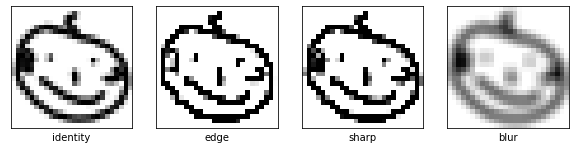

In [13]:
plt.figure(figsize=(10,10))
#Loop over kernel
for i,kernel in enumerate(kernels):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #return transformed image and plot it
    plt.imshow(run_kernel(myface,kernels[kernel]), cmap=plt.cm.binary,norm=norm(0,1))  
    plt.xlabel(kernel)
plt.show()



The kernel types match how they transform the images as expected.

## Image classification (3.5 mark)
---
In this section, we will train a convolutional neural network (CNN) to perform hand-written digit recognition; a standard form of image classification. We will:
- create the model
- train the model
- evaluate its classification performance

#### 3. Define a Convolutional Neural Network suitable for image classification (1 mark).

* Use the **`Keras` functional API** to construct the model. 
* The shape of the input layer should match the shape of the prepared images.
* Add some **convolutional** and **pooling** layers in a sensible configuration. The architecture is a bit up to you, but try to reach a good level of accuracy. Around 85% on validation seems easily achievable.
    * By default, you can use $3 \times 3$ kernels, ReLU activation, and $2\times 2$ pooling; but feel free to play around with different values.
    * By default no padding is applied. You could try "same" padding in order to use the whole image, though results don't change much for me.
    * If sufferening from large overtraining 
* **Flatten** the output of the last convolutional layer.
* Connect it, to an **output** layer with the appropriate number of nodes and choice of activation function.
* Display the model architecture using the `<model>.summary()` method. Optionally display it also with the `plot_model(<model>, show_shapes=True)` method.  
* Questions:
    * _What are the number of trainable parameters in the model?_
    * _How many trainable parameters does your first convolutional layer have? Why?_
    * _Which layer has the most trainable parameters?_

In [14]:
input = Input(shape=(28, 28, 1))
# 3 conv layers, each followed by a maxpool layer 
conv1 = Conv2D(16, kernel_size=3, padding='same', activation='relu')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(8, kernel_size=3, padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(4, kernel_size=3, padding='same', activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)
# Instructions don't say but added two dense layers before output dense layer
hidden1 = Dense(10, activation='relu')(flat)
hidden2 = Dense(10, activation='relu')(hidden1)
# Output has ten nodes, one for each unique target labels and sigmoid is used to keep outputs between 0 and 1
output = Dense(10, activation='sigmoid')(hidden2)
model = Model(input, output)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           292       
_________

- 2202 total trainable parameters.
- First conv layer  has 160 trainable parameters because it has 16 filters going over a (28x28) greyscale (one channel so once over), each with 3x3 + 1 (bias) = 10 trainable parameters so 16x10 = 160
- The second conv layer has the most trainable parameters with 1160

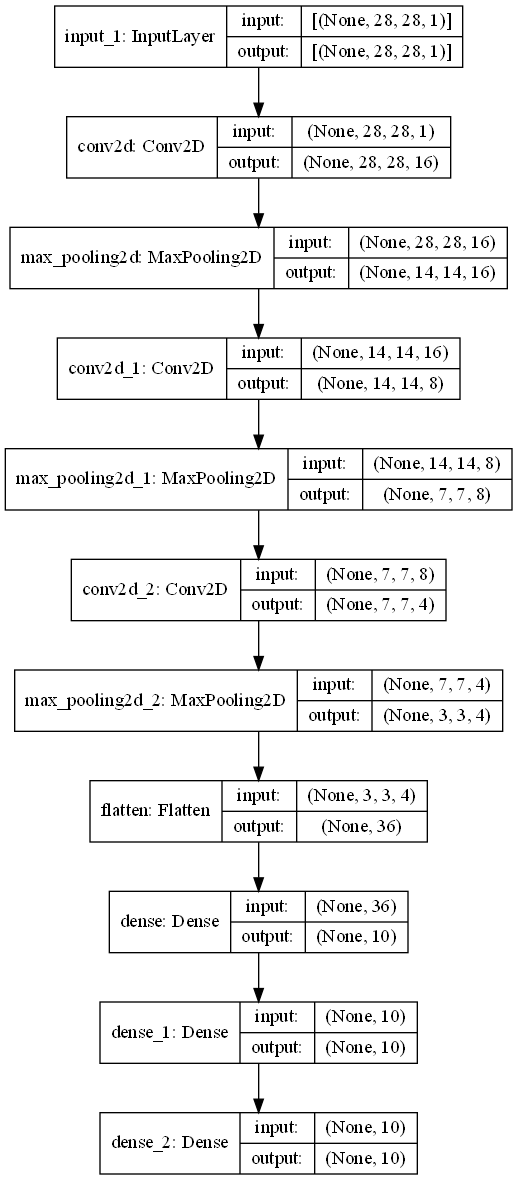

In [15]:
plot_model(model, show_shapes=True)

#### 4. Compile and train the CNN image classifier (1 mark)

* Choose the appropriate loss functiton. 
* Fit for a reasonable number of epochs, use 20% of data for validation. 
* Plot the loss curve(s) by using `matplotlib.pyplot` directly with the information in the `<model>.history.history` dict.
* If you run on CPUs, stretch your legs while you wait for the 20 epoches to complete. Now is a good time for a coffee/loo break!

In [16]:
# Sparse_catagorical_crossentropy as targets not one-hot encoded
# Compile and fit
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_history = model.fit(X_train, y_train, epochs=20, batch_size=32, shuffle=True, validation_split=0.2)

Train on 128000 samples, validate on 32000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
128000/128000 [==============================] - 66s 519us/sample - loss: 1.1456 - acc: 0.6192 - val_loss: 0.8827 - val_acc: 0.7240
Epoch 2/20
128000/128000 [==============================] - 78s 607us/sample - loss: 0.8225 - acc: 0.7406 - val_loss: 0.7824 - val_acc: 0.7527
Epoch 3/20
128000/128000 [==============================] - 64s 497us/sample - loss: 0.7503 - acc: 0.7617 - val_loss: 0.7301 - val_acc: 0.7687
Epoch 4/20
128000/128000 [==============================] - 62s 487us/sample - loss: 0.7149 - acc: 0.7712 - val_loss: 0.7192 - val_acc: 0.7714
Epoch 5/20
128000/128000 [==============================] - 62s 482us/sample - loss: 0.6922 - acc: 0.7779 - val_loss: 0.6976 - val_acc: 0.7751
Epoch 6/20
128000/128000 [==============================] - 61s 476us/sample - loss: 0.6730 - acc: 0.7825 - val_loss: 0.6807 - val_acc: 0.78

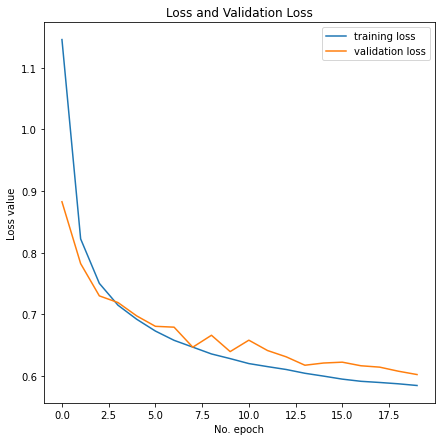

In [17]:
plt.figure(figsize=(7, 7))
plt.plot(model_history.history['loss'], label='training loss')
plt.plot(model_history.history['val_loss'], label='validation loss')
plt.title('Loss and Validation Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

Perhaps could use more complex model as acc. only about 0.80 but from graph it looks like model has not finished learning as  no plateau in losses yet. Should run for more epochs but instructions say 20 so I have just left it as is.

#### 5. Evaluate the classification performance on the testing dataset (1 Mark)

* Compute the testing accuracy, _e.g._ using the `<model>.evaluate()` method. Compare to the training accuracy; can be read off from fit printout, if you added the `'accuracy'` metric, or can be calculated here.
* Display a few mis-classified images from the test dataset.
    * For this you will need to use the model to predict from the testing features.
    * This yields arrays of 10 probabilities, 1 per class. Get the index from maximum probability to find the class prediction. Maybe consider using `argmax`?
* Compute and display the confusion matrix (normalise by truth label). Discuss the results.

In [18]:
res_loss_train, accuracy_train = model.evaluate(X_train, y_train)
res_loss_test, accuracy_test = model.evaluate(X_test, y_test)
print("Accuracy Training:",accuracy_train)
print("Accuracy Testing:",accuracy_test)

40000/40000 [==============================] - 6s 146us/sample - loss: 0.6134 - acc: 0.8044
Accuracy Training: 0.81205624
Accuracy Testing: 0.80445


Training and validation losses similar as expected from graph so not much overtraining. Should be trained longer to increase accuracy.

In [19]:
y_pred = np.argmax(model.predict(X_test), axis=1)

leg
foot
arm
nose
arm


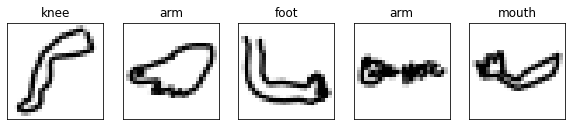

In [20]:
fig5 = plt.figure(figsize=(10,5))
misses = 0
i = 0
# For grid of five misclassified images. The true labels are printed above the grid in order left to right
while misses < 5:
    if y_pred[i] != y_test[i]:
        misses += 1
        print(body_parts[int(y_test[i])])
        plot_img(fig5, misses, X_test[i], y_pred[i], height=1)
    i += 1

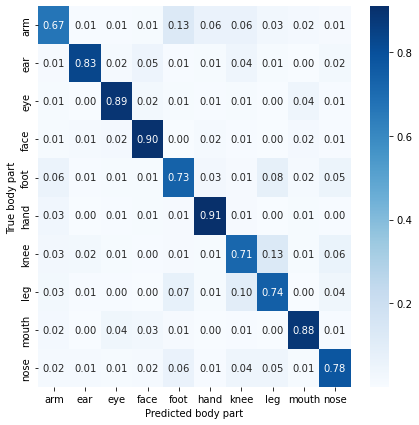

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

colormap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(7, 7))
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, fmt=".2f")
ax.set_ylabel('True body part');
ax.set_xlabel('Predicted body part');
ax.set_xticklabels(body_parts);
ax.set_yticklabels(body_parts);
plt.show()

The centre diagonal has much higher values meaning the model makes correct predictions most of the time. There are some higher incorrect probabilities like where model predicts knee but true label is leg which follows our own intuition as the images of knees and legs would probably look similar. The model best predicts hands and is worst at predicting arms.

For your own interest (not marked) run the first layer kernels over `myface`. You should see several copies of the image, all with varying transformations. In your training you may find different kernels, but I can clearly spot a bluring kernel in my first layer.

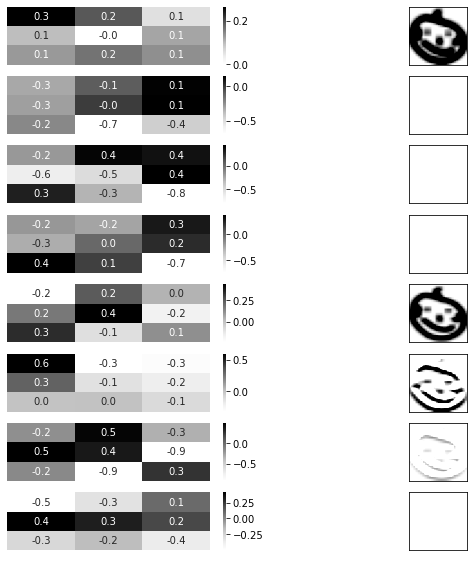

In [22]:
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(8,2,2*(i)+1)

    sns.heatmap(model.layers[1].get_weights()[0][:,:,:,i][:,:,0], cmap='Greys',annot=True,fmt=".1f")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplot(8,2,2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(run_kernel(myface,model.layers[1].get_weights()[0][:,:,:,i]),cmap=plt.cm.binary,norm=norm(0,1))
plt.show()


## Auto-encoders (3 marks)
---
In this section, we will construct and train an auto-encoder as an example of **unsupervised learning.** This type of model is made up of an **encoder** that maps an image of shape $(N,M,C)$ into a latent vector of shape $(L,)$; and a **decoder** which maps the latent vector into an image with the same shape as the original. The latent, or encoded, vector will typically be small in size compared to the input image (_i.e._ $L \ll N \times M \times C$), meaning that it is an **information bottleneck.** The aim of the auto-encoder is therefore to learn the most efficient encoding of a class of images (here: quickdraw dataset) that allows the decoder to reconstruct the original as well as possible under the bottleneck constraint.

We will break down this task into a few sub-tasks, to make it easier to get through.

#### 6. Construct the encoder (1 Marks)

* Use the `Keras` functional API to construct the encoder model. 
* The shape of the input layer should match the shape of the prepared images .
* Add some convolutional and pooling layers in a sensible configuration. 
    * Using a decreasing number of kernels for each convolutional layer (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) works quite well.
    * For this task it is worthwhile to give some thought to padding: You want to have intermediate layers with shapes that are easy to reconstruct with the decoder. As a starting point, consider using `padding='same'` for your conv. layers.
    * **See also the note below.**
* **Flatten** the output of the last convolutional layer, and use this as the latent vector. 
    * For convenience, we choose to make the latent vector have values in the range [0,1], so add the appropriate activation function to the preceeding convolutional layer.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * These methods are also very useful for debugging, when you are building your network. For instance, start with the simplest possible `Keras` model; plot the architecture using one of these methods; modify the model slightly; plot the architecture again to see the effect; _etc._
    * Make sure that the output of the encoder is indeed a bottleneck, _i.e._ that the number of output nodes is significantly smaller than the number of pixels in the image. (_Hint: A latent vector could have size $49 \ll 28 \times 28 \times 1 = 784$._)
    
**Note:** Choosing the architecture for an auto-encoder can be a bit tricky. The input images we use have shape $(28,28,1)$, and when we're pooling we typically downsample by a factor of $2$. If we use "same" padding, this means that we can go down to $(7,7,F)$ with no issues. However, if we downsample further (_e.g._ $7\to 3$) it will be tricky for the decoder to reconstruct, since upsampling would result in $3\to 6$. Therefore, to keep things simple, it may be best to not downsample further than $(7,7,F)$. However, you can still add _multiple convolutional layers in a row without pooling._

In [23]:
input_img = Input(shape=(28, 28, 1))

# Using recommended decreasing number of filters
x1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x2 = MaxPooling2D((2, 2), padding='same')(x1)
x3 = Conv2D(8, (3, 3), activation='relu', padding='same')(x2)
x4 = MaxPooling2D((2, 2), padding='same')(x3)
x5 = Conv2D(4, (3, 3), activation='relu', padding='same')(x4)
x6 = Conv2D(2, (3, 3), activation='relu', padding='same')(x5)
x7 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x6)
# Flatten to give 49 long 1D latent vector
encoded = Flatten()(x7)

encoder = Model(input_img, encoded)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 2)           74  

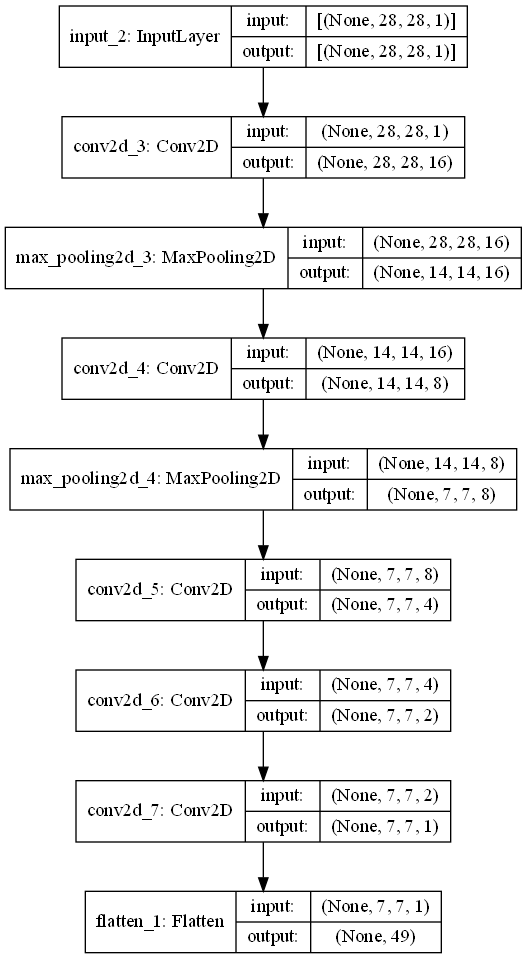

In [24]:
plot_model(encoder, show_shapes=True)

#### 7. Construct the decoder (1 Mark)

* Use the `Keras` functional API to construct the decoder model. 
* **Reshape** the latent vector to have the shape of the last convolutional layer in the encoder.
* The shape of the input layer should match the shape of the latent vector.
* Add some convolutional and **upsampling** layers in a sensible configuration. 
    * You can use the same order of kernels (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) as in the encoder.
    * Many of the notes and considerations mentioned for the encoder hold for the decoder as well.
* The output of the decoder should have the same shape as the number images. Also, choose an output activation that is appropriate to the dataset.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * As for the encoder, these methods can be very useful for debugging.

In [25]:
latent_input = Input(shape=(49))
# Reshape back to 7x7 latent grid ready for following layers
d1 = Reshape((7, 7, 1))(latent_input)
# Effectively mirror encoder
d2 = Conv2D(2, (3, 3), activation='relu', padding='same')(d1)
d3 = Conv2D(4, (3, 3), activation='relu', padding='same')(d2)
d4 = Conv2D(8, (3, 3), activation='relu', padding='same')(d3)
d5 = UpSampling2D((2, 2))(d4)
d6 = Conv2D(16, (3, 3), activation='relu', padding='same')(d5)
d7 = UpSampling2D((2, 2))(d6)
# Sigmoid at the end to get greyscale pixel values between 0 and 1
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d7)

decoder = Model(latent_input, decoded)
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 2)           20        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 4)           76        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 8)           296       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 16)        1168

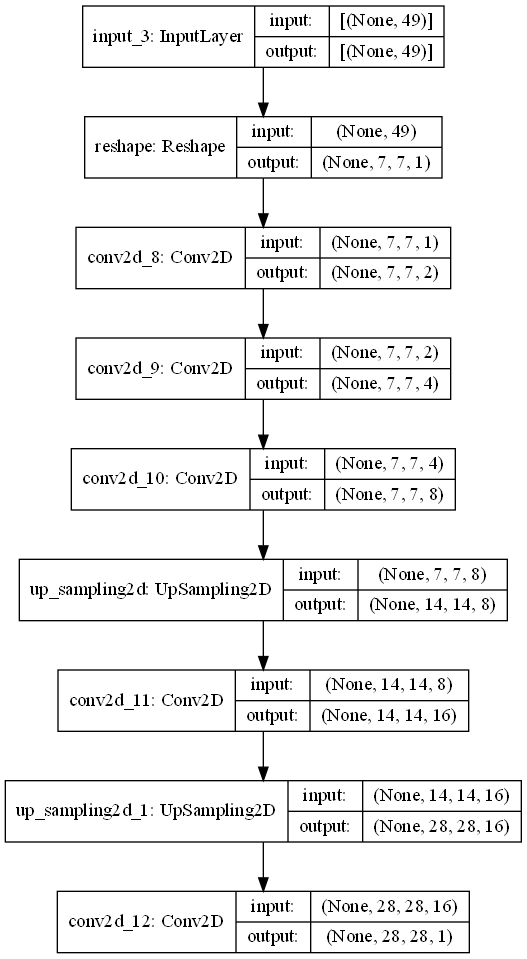

In [26]:
plot_model(decoder, show_shapes=True)

#### 8. Construct the auto-encoder (given, not marked)

Connecting the encoder and decoder to form the auto-encoder is a slightly tricky use of the `Keras` functional API, so I'll just give that to you. Assuming you have given you encoder and decoder intuitive names, the following should do the trick:

In [27]:
i   = encoder.input
cae = Model(i, decoder(encoder(i)), name='ConvAE')
cae.summary()

Model: "ConvAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_1 (Model)              (None, 49)                1705      
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         1705      
Total params: 3,410
Trainable params: 3,410
Non-trainable params: 0
_________________________________________________________________


Try to make sure that you understand what is going on here: In the `Keras` functional API, layers and even entire models work like functions (thus the name). What we're doing above is passing an input image `i` through the encoder (resulting in a latent vector); passing the output of `encoder` as the input to `decoder` (resulting in a reconstructed image); and finally using the output of `decoder` as the output of the auto-encoder.

#### 9. Compile and train the auto-encoder (1 Mark)

* Choose an appropriate loss function.
* Train for ca. 10 epochs with some data held out for validation. Time for another coffee break!
* Plot the loss curve(s).
* Perform the auto-encoding for the testing images (use the `<model>.predict()` method) and display the first couple of _(a)_ original and _(b)_ auto-encoded images to see whether the outputs resembles the original images.

In [28]:
# Binary_crossentropy for pixel-by-pixel comparison between input image and its reconstruction
cae.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Unsupervised so training X_train inputs, aiming for output to be reconstruction of X_train
cae_history = cae.fit(X_train, X_train,
                    epochs=10,
                    batch_size=32,
                    shuffle=True,
                    validation_split=0.2)

Train on 128000 samples, validate on 32000 samples
Epoch 1/10
128000/128000 [==============================] - 232s 2ms/sample - loss: 0.2070 - acc: 0.7687 - val_loss: 0.1733 - val_acc: 0.7775
Epoch 2/10
128000/128000 [==============================] - 228s 2ms/sample - loss: 0.1644 - acc: 0.7790 - val_loss: 0.1598 - val_acc: 0.7798
Epoch 3/10
128000/128000 [==============================] - 227s 2ms/sample - loss: 0.1579 - acc: 0.7803 - val_loss: 0.1563 - val_acc: 0.7802
Epoch 4/10
128000/128000 [==============================] - 225s 2ms/sample - loss: 0.1549 - acc: 0.7809 - val_loss: 0.1539 - val_acc: 0.7809
Epoch 5/10
128000/128000 [==============================] - 226s 2ms/sample - loss: 0.1533 - acc: 0.7813 - val_loss: 0.1526 - val_acc: 0.7814
Epoch 6/10
128000/128000 [==============================] - 227s 2ms/sample - loss: 0.1522 - acc: 0.7814 - val_loss: 0.1542 - val_acc: 0.7809
Epoch 7/10
128000/128000 [==============================] - 226s 2ms/sample - loss: 0.1515 - acc:

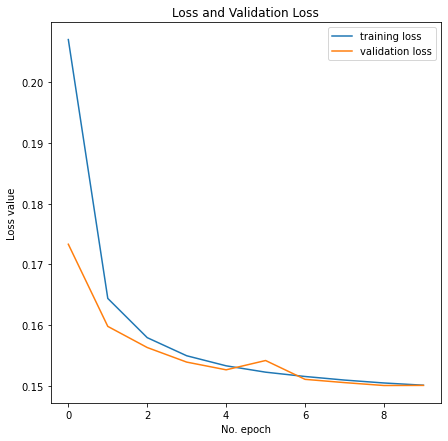

In [29]:
plt.figure(figsize=(7, 7))
plt.plot(cae_history.history['loss'], label='training loss')
plt.plot(cae_history.history['val_loss'], label='validation loss')
plt.title('Loss and Validation Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

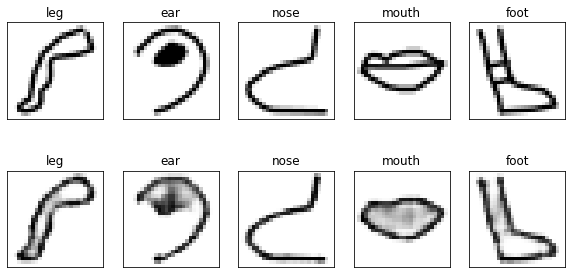

In [30]:
X_pred = cae.predict(X_test)
fig_compare = plt.figure(figsize=(10,5))

# Compare originals to reconstructions displaying labels unknown to the model
for i in range(5):
    plot_img(fig_compare, i+1, X_test[i], y_test[i])
    plot_img(fig_compare, i+6, X_pred[i], y_test[i])

The outer edges look decent but it fails to recreate some of the finer details so look a bit blurred.

#### 10. Plot images in the laten space
- Predict 10 images into the laten space using the encoder only.
- Reshape the output to images and plot the laten space images. e.g. if your encoder outputs 49 features, make 7x7 image

In [31]:
# Predict latent vectors using encoder only
latent_pred = encoder.predict(X_test)

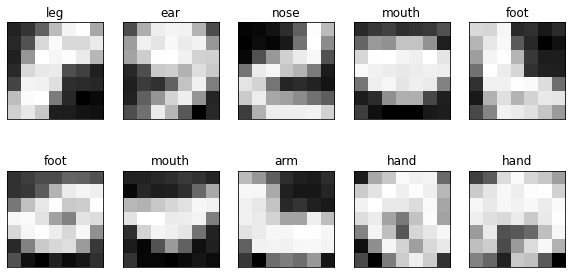

In [32]:
# Plot 7x7 latent grid 'images'
latent_space = []
for i in range(len(latent_pred)):
    latent_space.append(np.reshape(latent_pred[i], (7, 7)))
    
fig_latent = plt.figure(figsize=(10,5))

for i in range(10):
    plot_img(fig_latent, i+1, latent_space[i], y_test[i])

## Anomaly detection (2 marks)
---

We have introduced auto-encoders as a form of unsupervised learning, since we are not using the image labels during training. This means that auto-encoders are not ideal for image classification (at least not since we actually _have_ the labels), but they can be used for something else: anomaly detection. This is the task of identifying examples that the model considers "anomalous" with respect to the dataset used during training. 

First, we'll load in some "anomalous" data:

In [33]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces(shuffle=True)['images']
faces = faces[:,4:-4:2,4:-4:2,np.newaxis]

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Matthew\scikit_learn_data


In [34]:
def plot_new_img(fig, index, X, width=5, height=2):
    # Same as previous plotting to grid function but not requiring a label as new faces are not labelled
    ax = fig.add_subplot(height, width, index)
    ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False)
    ax.imshow(X, cmap=plt.cm.binary)

#### 9. Inspect the face images and the auto-encoder result (1 mark)

* How many samples does the "outlier" dataset (_i.e._ `faces`) contain?
* What is the shape of the images and what is the range of pixel intensities? Does this conform with the preprocessed quickdraw images?
* Display the first few face images.
* Get the output/prediction of the auto-encoder from the previous section when applied to all of the faces.
* Show the auto-encoded versions of the same faces you showed above. Discuss the results.

In [35]:
print('There are {} outlier images.'.format(len(faces)))
print('The shape of an outlier image is {}.'.format(faces[0].shape))
print('The range of pixel intensities is {} to {}.'.format(faces.min(), faces.max()))

There are 400 outlier images.
The shape of an outlier image is (28, 28, 1).
The range of pixel intensities is 0.020661156624555588 to 0.9710744023323059.


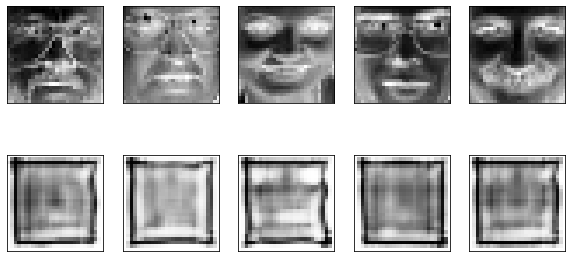

In [36]:
# Run new faces as inputs through same cae as before
faces_pred = cae.predict(faces)
fig_faces_compare = plt.figure(figsize=(10,5))

# Plot input and attempted reconstruction below each
for i in range(5):
    plot_new_img(fig_faces_compare, i+1, faces[i])
    plot_new_img(fig_faces_compare, i+6, faces_pred[i])

Although the shapes and pixel ranges are the same as for the dataset the AE was trained on so the network is able to attempt to encode and decode them, the outliers are much different to all the quickdraw images. This means they are very poorly encoded and hence poorly reconstructed as they don't share the same features as the quickdraw bodyparts used in training.

_Indicative answers:_
    
* The face images have the same shape and pixel intensity range as the preprocessed quickdraw images, so they are valid inputs to the auto-encoder.
* We can see that the auto-encoder transformed faces are _very_ unlike the input images. This is because the auto-encoder was trained to learn an efficient representation of hand-written digits which is not necessarily an efficient representation for other image domains, _e.g._ faces. This examples shows that this is clearly the case. From the point of view of the auto-encoder, images of faces are _anomalies_ in that they are fundamentally unlike the images on which it was trained, and therefore we shouldn't expect it to do a good job in encoding them.

#### 11. Perform anomaly detection (1 mark)
Imagine now that we had a dataset comprised of mostly quickdraw images, but also a small subset of anomalies or "outliers"; here, in the form of black-and-white images of faceses, with the same shape as the quickdraw images.

In [37]:
# Combined MNIST images and "outliers" in a mixed dataset
mixed = np.vstack((X_test, faces))

# Shuffle the mixed dataset so the "outliers" are randomly distributed
indices = np.random.permutation(mixed.shape[0])
mixed   = mixed[indices]

The auto-encoder was trained to minimise the difference between the original and the auto-encoded image, so let's use binary cross-entropy (BCE) as our metric for the difference between an image and its auto-encoded version. The `binary_crossentropy` method provided below computes **pixel-wise BCE** for two (arrays of) images: the input and the output image.

In [38]:
def binary_crossentropy (img_in, img_out):
    assert img_in.shape == img_out.shape
    eps = np.finfo(float).eps
    img_out = np.clip(img_out, eps, 1. - eps)
    return - (img_in * np.log(img_out) + (1 - img_in) * np.log(1 - img_out))

---
* Define a new method called `difference` which takes as input two arrays of images (`img_in` and `img_out`; similar to the `binary_crossentropy`); computes the **average BCE value for each image,** or row; and returns a vector of these difference measures.
* For each image, or row, in `mixed`, compute the difference score of the auto-encoded image wrt. the original image. This is a measure of how "inlier"- or "outlier"-like an image is.
* Make a histogram of these scores, and see if you can identify any structure. It might be useful to use a logarithmic x-axis (see `plt.xscale`) along with logarithmic x-axis bins (see `np.logspace`).
* Show the 9 least and the 9 most outlying images, according to this difference score. Discuss the results.

In [39]:
def difference(imgs_in, imgs_out):
    # Returns array of average bce's for a set of images
    av_bce_vector = []
    for i in range(len(imgs_in)):
        bce = binary_crossentropy(imgs_in[i], imgs_out[i])
        av_bce_vector.append(np.mean(bce))
    return np.array(av_bce_vector)

Text(0.5, 1.0, 'Histogram of mixed differences')

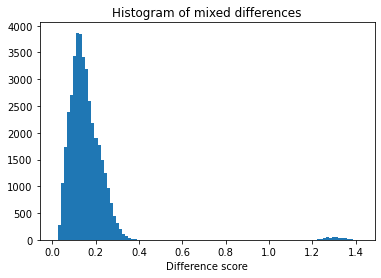

In [40]:
recon_mixed = cae.predict(mixed)
# Get scores for mixed set
diffs = difference(mixed, recon_mixed)
# Plot histogram
plt.hist(diffs, bins=100)
plt.xlabel("Difference score")
plt.title("Histogram of mixed differences")

Can see majority of images are at low end of difference score. There are the well reconstructed images similar to the training set. There is a small cluster with high difference corresponding to the outlier faces.

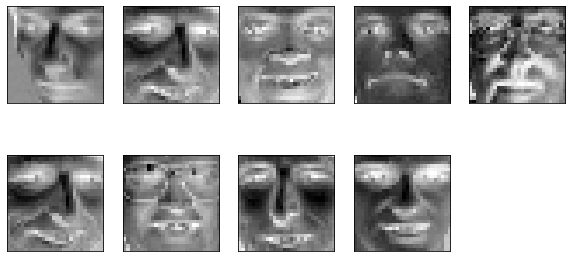

In [41]:
# Get indices of 9 highest diff scores
top_nine_indices = diffs.argsort()[-9:][::-1]

fig_high = plt.figure(figsize=(10,5))
k = 0
for index in top_nine_indices:
    plot_new_img(fig_high, k+1, mixed[index])
    k += 1

As expected the highest diff scores are all outlier face images.

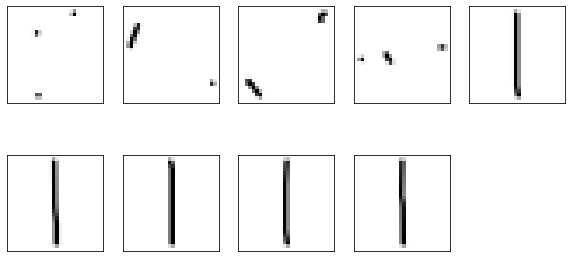

In [42]:
# Get indices of 9 lowest diff scores, (highest of negative of scores)
bottom_nine_indices = (-diffs).argsort()[-9:][::-1]
fig_high = plt.figure(figsize=(10,5))
l = 0
for index in bottom_nine_indices:
    plot_new_img(fig_high, l+1, mixed[index])
    l += 1

The best (lowest) diff scores are very simple quickdraw-like images, ie mostly white with thick edges and minimal detail, that were easy to reconstruct.